# Create TFRecord dataset

TFRecord is the native file type of tensorflow. TFRecord does not support appending

References:
* https://indico.io/blog/tensorflow-data-inputs-part1-placeholders-protobufs-queues/
* http://warmspringwinds.github.io/tensorflow/tf-slim/2016/12/21/tfrecords-guide/
* http://stackoverflow.com/questions/36026892/how-can-i-convert-tfrecords-into-numpy-arrays
* https://gist.github.com/blondegeek/724308125c0cdb795b617c7132148d12
* https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/how_tos/reading_data/convert_to_records.py

In [1]:
import tensorflow as tf
import numpy as np
import scipy.misc
import random
import matplotlib.pyplot as plt
import sys

folder_dataset = "../Track1_Wheel/"
TFRECORD_PATH = '../Dataset.tfrec'

### Read dataset directory

In [2]:
# Lists to hold image filename and label
xs = []
ys = []

with open(folder_dataset + "data.txt") as f:
    for line in f:
        # Image path
        xs.append(folder_dataset + line.split()[0])        
        # Steering wheel label
        ys.append(np.float32(line.split()[1]))

num_images = len(xs)
print("Number of images: %d" % num_images)

# Use zip to create a list with images/labels
c = list(zip(xs, ys))
#random.shuffle(c)
xs, ys = list(zip(*c))

Number of images: 1660


### Load images into memory(as ndarray)

In [3]:
list_imgs = []
for imPath in xs:
    image = scipy.misc.imread(imPath, mode="RGB")
    list_imgs.append(image)


# Just print to debug
print(list_imgs[0].shape)

(256, 256, 3)


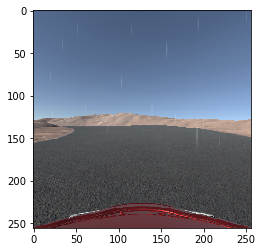

Wheel angle: -0.118857


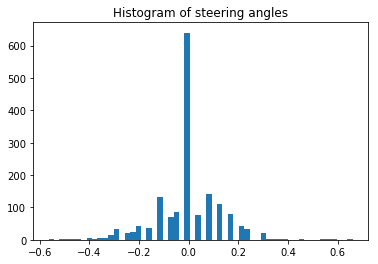

In [4]:
rand_index = random.randint(0,len(list_imgs)-1)
plt.imshow(list_imgs[rand_index])
plt.show()
print('Wheel angle:', ys[rand_index])
plt.hist(ys,bins='auto')
plt.title("Histogram of steering angles")
plt.show()

### Calculate sizes

In [5]:
# get size in bytes of lists
size_bytes_images = list_imgs[0].nbytes * len(list_imgs)
size_bytes_labels = ys[0].nbytes * len(ys)
total_size = size_bytes_images + size_bytes_labels
print('Total size(bytes): %d' % (size_bytes_images+size_bytes_labels))
print('Number of elements:', len(ys))
print('Type of images: ', type(list_imgs), 'of', list_imgs[0].dtype)
print('Type of labels: ', type(ys), 'of', ys[0].dtype)

# Convert shape tupple into string separated with '_
shape_img = list_imgs[0].shape
shape_str = '_'.join([str(dim) for dim in shape_img])
print('Image shape',shape_img)
print('Image size in bytes',list_imgs[0].nbytes)

Total size(bytes): 326375920
Number of elements: 1660
Type of images:  <class 'list'> of uint8
Type of labels:  <class 'tuple'> of float32
Image shape (256, 256, 3)
Image size in bytes 196608


## Create TFRecord dataset

In [6]:
writer = tf.python_io.TFRecordWriter(TFRECORD_PATH)

In [7]:
# Iterate on batch    
for (tup_element) in list(zip(list_imgs, ys)):
    img,steer = tup_element
    # Convert to numpy array to get bytes more easy
    shape_info = np.array(img.shape)        
    
    # Describe record entry
    example = tf.train.Example(        
        # Record description 
        features=tf.train.Features(                      
            feature={
                # A Feature contains one of either a int64_list, float_list, or bytes_list            
                'label': tf.train.Feature(
                    float_list=tf.train.FloatList(value=[steer])),
                'shape': tf.train.Feature(
                    bytes_list=tf.train.BytesList(value=[shape_info.tobytes()])),
                'image': tf.train.Feature(
                        bytes_list=tf.train.BytesList(value=[img.tobytes()] ) ),
    }))

    # use the proto object to serialize the example to a string
    serialized = example.SerializeToString()
    # write the serialized object to disk
    writer.write(serialized)

# Close file    
writer.close()

### Select some element and display

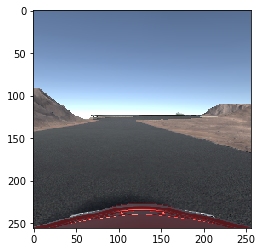

Wheel angle: 0.0


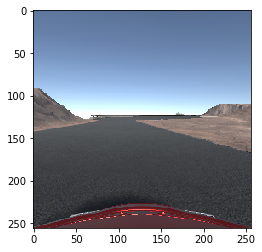

Wheel angle: 0.0


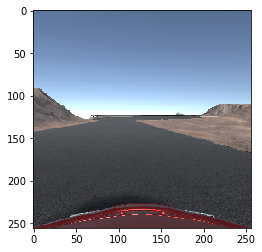

Wheel angle: 0.0


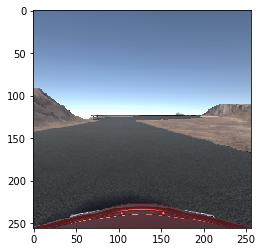

Wheel angle: 0.0


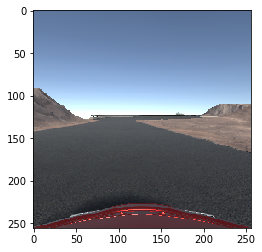

Wheel angle: 0.0


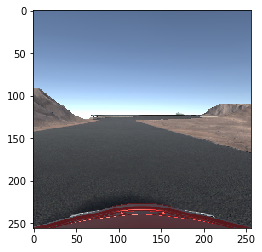

Wheel angle: 0.0


In [8]:
# Get some elements
numElements = 0
for serialized_example in tf.python_io.tf_record_iterator(TFRECORD_PATH):
    example = tf.train.Example()
    example.ParseFromString(serialized_example)

    shape_bytes = example.features.feature['shape'].bytes_list.value
    shape = np.frombuffer(shape_bytes[0], dtype=np.int64)    
    
    # traverse the Example format to get data
    image_bytes = example.features.feature['image'].bytes_list.value    
    #print(type(image[0]))
    image = np.frombuffer(image_bytes[0], dtype=np.uint8).reshape(shape)
    label = example.features.feature['label'].float_list.value
    plt.imshow(image)
    plt.show()
    print('Wheel angle:', label[0])      
    numElements += 1
    if numElements > 5:
        break